# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 4 - Evaluating a PyTorch ResNet152 convolutional neural network (CNN) using a held out validation image set.

This notebook shows how to assess the performance of a ResNet152 CNN model using the CUB-200-2011 database of birds. Given a set of held-out test images from the 200 classes of birds, we will use the images to perform prediction, that is, show the network each image and get it to produce a prediction of class. As we have the true class labels, we can perform a number of evaluation techniques comparing the predicted labels to the true labels, to get an idea of how our model performs with this fine-grained image classification problem. We will see how to load a model, and pass both single images and test datasets for prediction.

The previous notebooks showed how to train a ResNet 152 model which had been initialised with pre-trained weights from ImageNet, for the task of fine grained image classification of bird species using the CUB-200-2011 dataset.

This is the fourth stage of our roadmap for building and understanding a birds image classifier:

![RoadMapImage](../docs/birds_roadmap.png)

This notebook is now going to show: 

    1. How to set up a dataloader for use as a test image set loader.
    
    2. How to load a trained ResNet152 model on the CUB-200-2011 dataset, and setup ready for performing inference (prediction).
    
    3. How to perform model inference using a held out test image set to create a vector of predicted class labels and/or class probabilities.
    
        a. On a single image.
        
        b. On a test image set.
    
    4. How to evaluate the predictions from a neural network using the following approaches:
    
        a. Metrics and classification report.
        
        b. Confusion matrix.
        
        c. ROC and Precision / Recall Curves
    
    5. Misclassification investigations using class probabilities.

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model, visualize_model_grid
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.evaluation import make_predictions_proba
from cub_tools.network import softmax

### Runtime setup

In [2]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

## Dataloaders

As before, we setup the dataloaders and transformations for feeding into the neural network.

In this example, we only need to load the test image dataset, as we are loading the pre-trained model from the previous network.

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

## Device setup and model load

We now need to specify the device, again this time we will be using a GPU if available, CPU if not.
Single image inference should be tractable on a CPU, however full test set evaluation will need a GPU.

Following the device setup, we then load the CUB-200-2011 trained ResNet152 model.

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [6]:
# Load the best model from file
model_ = torch.load(model_file)

/home/edmorris/.local/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/edmorris/.local/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/edmorris/.local/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the

## Single image predictions

In this section, we provide a function with the model, class names, the device to run the prediction on (in this case a GPU), and the test set data loader

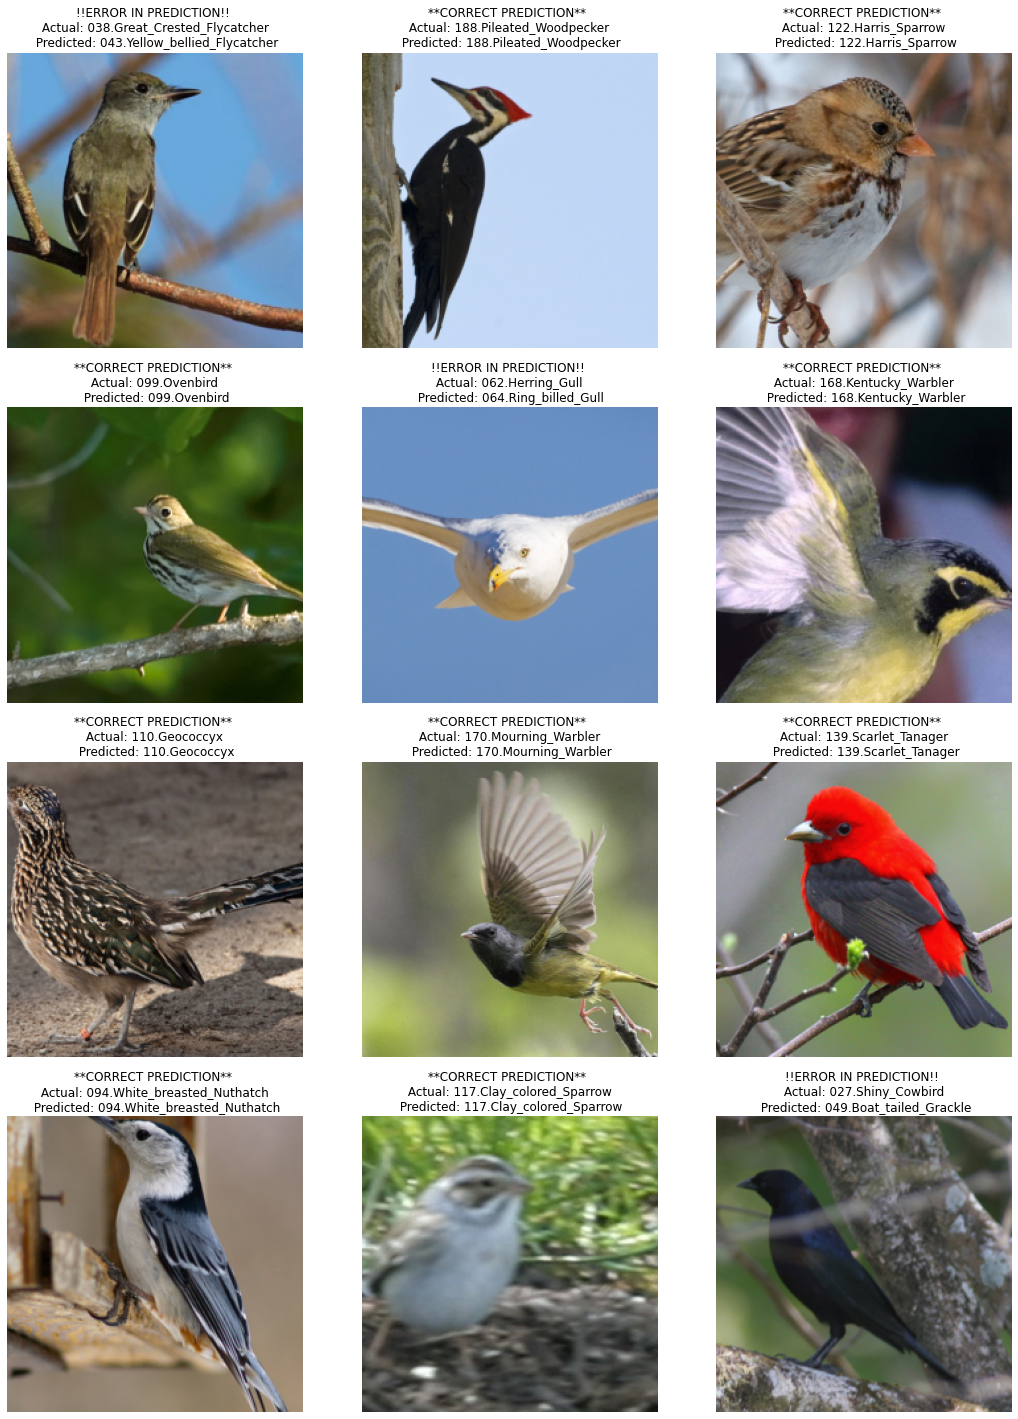

In [7]:
visualize_model_grid(model=model_, class_names=class_names, device=device, dataloaders=dataloaders, num_images=12, figsize=(18,25))

## Evaluation over the whole test set

Now we are going to perform an evaluation on all ~6000 images of the test set to get a really good idea at how our network is performing.

The function below returns 3 objects in a python dictionary.

1. True labels vector.

    n x 1 vector of integers from 1 to 200 indicating true class label for the image.

2. Predicted labels vector.

    n x 1 vector of integers from 1 to 200 indicating the predicted label for the image.

3. Scores matrix.

    n x c matrix of probabilities in the range of 0 to 1.0, where c is the number of classes.

In [8]:
results_dict = make_predictions_proba(model=model_, dataloaders=dataloaders, device=device)

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..

KeyboardInterrupt: 

## Classification metrics evaluation

### Classification Report

Now that we have the predictions vector and the scores vectors for each prediction, we need to make an assessment on the performance of the model.

The simplest way is to compare the number of predictions that are correct, and the number that are incorrect for each class. That will give us an assessment of how well the model is performing. If we take an average of this over all the classes, we get the class average performance of the model. The key classification metrics will described are shown in the below diagram, wich are a combination of understanding how well an algorithm predicts the correct class, in the context of other classes:

![Precision Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)    

In [ ]:
print(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names))

If we turn the classification report into a usuable format, in a Pandas DataFrame, we can use the metrics data itself to create visualisations, to help better illustrate how the model is performing.

We can also look at more easily, which classes are the model performing well on, and which is consistently having issues with.

These can inform us on whether the model is performing adequately for our purposes, and also suggests potential avenues where we might focus on to improve the performance.
This might involve getting more data, presenting the data differently, or thinking of other algorithms that may perform better.

Plotting the Precision, Recall and F1-Score for all classes and sorting by magnitude allows to us very easily identify which classes are performing poorly.
In this example we can see that Gulls, Terns and Crows/Ravens come up quite a bit as poor performers.

In [ ]:
class_report_df = pd.DataFrame(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names, output_dict=True))
class_report_df

In [ ]:
# Full class list metrics

plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2,[0, len(class_names)], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, len(class_names)], 'r--')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, len(class_names)], 'r--')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [ ]:
# Worst 25 classes metrics
n_classes = 25
    
plt.figure(figsize=(4,6))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2, [0, n_classes], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.xlim([0., 1.])
plt.title(model)

plt.figure(figsize=(4,6))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, n_classes], 'r--')
plt.xlabel('Recall Score')
plt.title(model)
plt.xlim([0., 1.])
plt.grid(True)

plt.figure(figsize=(4,6))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, n_classes], 'r--')
plt.xlabel('F1 Score')
plt.title(model)
plt.xlim([0., 1.])
plt.grid(True)

### Confusion Matrix

Instead of looking at each class indepently, let's now use a technique to look at how all the classes performed relative to each other. One of the ways this can be effectively achieved is through the use of the so-called [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). This allows to compare the performance of each class against each other, where we plot the actual labels against predicted ones. 

**Perfect Accuracy**

If the model achieved perfect accuracy, then we would expect to see a matrix representation with only a diagnonal present with the number of samples per class. This tells us that for every image with that class label, the model correctly predicted the right class. 

**Mis-classifications**

If the model was less than perfect, then the classification matrix helps us see which classes performed poorly, and what classes they were mis-classified as. This is represented as off-diagonal "heat" in the below heat map. In our example, we remember that Gulls performed as one of the worst classes of bird, and we can see from the classification matrix heat map below the weaker colours associated with the Gulls, and the scatter of "heat" from the diagonal. This is telling us the algorithm accuracy with these classes is poorer for some reason. Simimlar can be seen with the Terns and Swallows.

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred']), index=class_names, columns=class_names)

In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [ ]:
classes_to_plot = [143, 49, 52]
title_str = '\n'
for class_ in classes_to_plot:
    title_str = title_str + ' ' + class_names[class_] +'\n'

plot_precision_recall(y_true=results_dict['labels truth'], y_probas=results_dict['scores pred'], figsize=(10,10), 
                      classes_to_plot=classes_to_plot, title='Precision Recall for'+title_str)
plt.grid(True)
plt.show()

## Investigation of a misclassified results

We have seen how the model performs generally, and across particular classes, and we can see that whilst there is generally a good level of accuracy obtained there are certain species of bird (or class) where we have a lower than average performance.

To understand why that might be the case, the first part of the investigation looks at the class probabilities. Instead of taking the class prediction as the output, we will look at the underlying probabilities of each class. In fact, what we find is that the output of the model is not a single class prediction, but a vector of probabilities for the likelihood of the picture containing each of the classes of birds. To produce the class prediction, we have simply looked up the class with the highest probability and chosen to use that the model prediction.

Instead, for selected examples we can choose to look at the class probablility distributions to see what other types of birds the mis-classified picture are featuring strongly in terms of increased probability. The sorts of questions we are asking here are:

    1. Is there a single class that has a strong probability that is incorrect, or are there a number of classes that are equally likely, with one of them being the correct class, (although not the larget)?
    
    2. Are there are any reasons why we think other classes of birds are resulting in elevated probabilities compared to the true class of the bird?

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

### Sort the misclassified images

Here we sort through the misclassified images where the prediction is wrong, and we create a dictionary which includes the true and predicted labels of the image, and the probability distributions for each of the images.

In [ ]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [ ]:
misclass_scores_df = pd.DataFrame(misclass_scores)
misclass_scores_df

### Calculate misclassification summaries

Now we are interested in a number of different summary metrics.

    1. How many misclassifications are there per bird class?
        The **number of misclasses** gives us this measure.
    
    2. For each bird class, what are the classes of birds that the current class is being incorrectly predicted as?
        The **misclass classes** field gives us the breakdown of which classes the current class has been incorrectly classified as, and how many times this has occurred.

In [ ]:
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('+   MISCLASSIFICATION SUMMARY of CUB-200-2011 Test Set    +')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('CNN Model:: {}'.format(model))
print('')
misclass_summary = {}
misclass_summary['number of misclasses'] = {}
misclass_summary['misclass classes'] = {}
for class_ in np.sort(misclass_scores_df['label truth'].unique()):
    misclass_summary['number of misclasses'][class_names[class_]] = (misclass_scores_df['label truth'] == class_).sum()
    
    misclass_summary['misclass classes'][class_names[class_]] = {'class':[], 'count':[]}
    str = 'Class:: {} :: '.format(class_names[class_])
    for misclass_class in misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_].unique():
        str = str + '\n \t \t \t {} ({}) '.format(class_names[misclass_class], (misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_] == misclass_class).sum())
        misclass_summary['misclass classes'][class_names[class_]]['class'].append(class_names[misclass_class])
        misclass_summary['misclass classes'][class_names[class_]]['count'].append((misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_] == misclass_class).sum())
    print(str)

### Plot the misclassification summaries

Here we are looking at the total number of misclassifications per class with classes that have prediction errors.
The graph has been sorted in number of misclassifications to make interpretation easier.

The plots following are a more detailed look at the individual misclassifications for the 25 birds classes that have the worst performance.
The graphs show the incorrectly predicted bird classes that were predicted for a given class. For example, the worst performing class is shown to be the Herring Gull with 22 misclassifications out of 30 images. The misclassification class plot shows us that a number of different bird classes are predicted incorrectly for Herring Gulls and include other gulls, terns, a kittiwake and Jaegar. Domain knowledge in this instance tells us that this is not surprising as these are all sea birds with similar visual aspects of the gulls.

In [ ]:
pd.DataFrame(misclass_summary).sort_values(by=['number of misclasses'], ascending=False).plot(kind='bar', figsize=(30,4))
plt.grid(True)
plt.title(model+' - Number of misclassified cases (images) for a given bird class')
plt.show()

In [ ]:
sorted_misclass_index = pd.DataFrame(misclass_summary).sort_values(by=['number of misclasses'], ascending=False).index.to_list()

for class_ in sorted_misclass_index[0:25]:
    plt.figure(figsize=(10,4))
    plt.bar(x=misclass_summary['misclass classes'][class_]['class'], 
            height=misclass_summary['misclass classes'][class_]['count'])
    plt.title(class_)
    plt.grid(True)
    plt.xticks(rotation=90)
plt.show()

### TODO

Here we can then take examples of the classes that have the most number of misclassifieds and look at what classes they often get classes as.

Perhaps we can look at the probability distributions somehow to compare across the classes for the images where it was incorrectly classifed? Violin plots or something?

In [ ]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [ ]:
class_id = 61
print('Selected Class {}'.format(class_names[class_id]))

In [ ]:
plt.figure(figsize=(28,12))
for i, scores in misclass_scores_df['scores'][(misclass_scores_df['label truth'] == class_id)].items():
    sns.lineplot(x=class_names,y=scores)
    plt.xticks(rotation=90)
    #plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[misclass_scores_df['label truth'][i]], class_names[misclass_scores_df['label pred'][i]]))
    plt.grid(True)
    plt.tight_layout()
    plt.ylim([0.0, 1.0])
plt.show()

In [ ]:
for i, scores in misclass_scores_df['scores'][(misclass_scores_df['label truth'] == class_id)].items():
    plt.figure(figsize=(28,6))
    plt.bar(class_names,height=scores)
    plt.xticks(rotation=90)
    plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[misclass_scores_df['label truth'][i]], class_names[misclass_scores_df['label pred'][i]]))
    plt.grid(True)
    plt.tight_layout()
    plt.ylim([0.0, 1.0])
plt.show()